# Informe Parte II Proyecto Detección Gestos de Mano

El presente documento pretende mostrar el desarrollo de una red neuronal convolucional que es capaz de clasificar tres gestos de la mano correspondientes a mano extendida, cerrada y gesto de dos dedos. Lo que es equivalente a los gestos de piedra, papel y tijera

In [1]:
import cv2
import os
import sys
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as k

from tensorflow.python.keras import applications

from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

### Análisis Inicial Exploración del dataset de imágenes

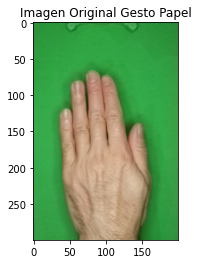

Ancho de la imagen: 200
Alto de la imagen: 300


In [2]:
img_source = cv2.imread("dataset_imagenes/train/papel/4Bimc2E5E9jTh1Fh.png")
ejemplo_img_papel = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)

ancho = ejemplo_img_papel.shape[1]
alto = ejemplo_img_papel.shape[0]

plt.imshow(ejemplo_img_papel)
plt.title('Imagen Original Gesto Papel')
plt.show()

print("Ancho de la imagen: {}".format(ancho))
print("Alto de la imagen: {}".format(alto))


 Número de imágenes para entrenamiento: 1321
 Número de imágenes para test: 359 



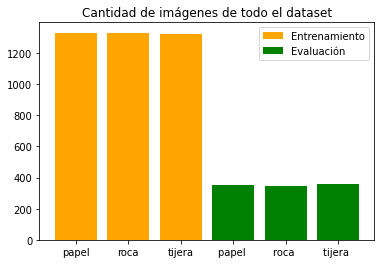

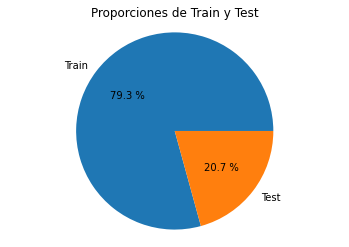

In [3]:
num_img_papel_train=len(glob.glob("dataset_imagenes/train/papel/*.png"))
num_img_papel_test=len(glob.glob("dataset_imagenes/test/papel/*.png"))

num_img_roca_train=len(glob.glob("dataset_imagenes/train/roca/*.png"))
num_img_roca_test=len(glob.glob("dataset_imagenes/test/roca/*.png"))

num_img_tijera_train=len(glob.glob("dataset_imagenes/train/tijera/*.png"))
num_img_tijera_test=len(glob.glob("dataset_imagenes/test/tijera/*.png"))

num_train = num_img_tijera_train
num_test = num_img_tijera_test

print('\n Número de imágenes para entrenamiento: {}'.format(num_train))
print(' Número de imágenes para test: {} \n'.format(num_test))

x = np.array(['papel','roca','tijera'])
y = np.array([num_img_papel_train,num_img_roca_train,num_img_tijera_train])
x2 = np.array(['papel ','roca ','tijera '])
y2 = np.array([num_img_papel_test,num_img_roca_test,num_img_tijera_test])


plt.bar(x,y,color="orange",align="center")
plt.bar(x2,y2,color="g",align="center")
plt.title("Cantidad de imágenes de todo el dataset")
plt.legend(["Entrenamiento", "Evaluación"], loc = 'best')
plt.show()

n_imgs = [num_img_roca_train,num_img_roca_test]
nombres = ["Train","Test"]
plt.pie(n_imgs, labels=nombres, autopct="%0.1f %%")
plt.axis("equal")
plt.title("Proporciones de Train y Test")
plt.show()


#### Definición de ImageDataGenerator de TensorFlow 
Alteramos las imágenes, en el caso de las imágenes de entrenamiento se habilitan reescalamiento, shear, zoom y flip que permitirán que nuestra red neuronal también aprenda cuando existen nuevos ángulos y cuando solo aprecen partes de la imagen e incluso si se cambia de dirección. Para el test únicamente reescalamos los pixeles.

In [4]:
k.clear_session()
data_entrenamiento = "dataset_imagenes/train"
data_test = "dataset_imagenes/test"

In [5]:
k.clear_session()
entrenamiento_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [6]:
altura, longitud = 100,100
pasos = 1000
pasos_validacion = 200
filtrosConv1 = 32
filtrosConv2 = 64
filtrosConv3 = 128
tamano_filtro1 = (3,3)
tamano_filtro2 = (2,2)
tamano_pool = (2,2)
clases = 3
lr = 0.001
batch_size=10 #número de imágenes a procesar en cada época

imagen_entrenamiento = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    #color_mode='grayscale',
    class_mode='categorical'
)

imagen_test = test_datagen.flow_from_directory(
    data_test,
    target_size=(altura, longitud),
    batch_size=batch_size,
    #color_mode='grayscale',
    class_mode='categorical'
)

Found 4386 images belonging to 3 classes.
Found 1104 images belonging to 3 classes.


## Modelo

Consta de capas de Entrada, Convoluciones, Aplanamiento, Fully Conected, Dropout y Salida

In [7]:
epocas = 25
cnn = Sequential()
opt = optimizers.Adam(learning_rate=lr)

cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", input_shape=(longitud, altura, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv2, tamano_filtro1, padding ="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv2, tamano_filtro1, padding ="same",activation='relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv2, tamano_filtro2, padding ="same",activation='relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv3, tamano_filtro1, padding ="same",activation='relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv3, tamano_filtro1,padding ="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Flatten())
cnn.add(Dense(256, activation='relu')) 
cnn.add(Dropout(0.5))
cnn.add(Dense(clases, activation='softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        1

### Entrenamiento

In [8]:
opt = optimizers.Adam(learning_rate=lr)
cnn.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

history = cnn.fit(imagen_entrenamiento, steps_per_epoch=100, epochs=epocas, validation_data=imagen_test,validation_steps=20)

dir = './modelo'

if not os.path.exists(dir):
    os.mkdir(dir)

cnn.save('./modelo/modelo.h5')
cnn.save_weights('./modelo/pesos.h5')

Epoch 1/25
100/100 [==============================] - 11s 102ms/step - loss: 1.1078 - accuracy: 0.3250 - val_loss: 1.0987 - val_accuracy: 0.3200
Epoch 2/25
100/100 [==============================] - 9s 90ms/step - loss: 1.0991 - accuracy: 0.3396 - val_loss: 1.0036 - val_accuracy: 0.3250
Epoch 3/25
100/100 [==============================] - 11s 105ms/step - loss: 0.8983 - accuracy: 0.5610 - val_loss: 0.4207 - val_accuracy: 0.8600
Epoch 4/25
100/100 [==============================] - 10s 103ms/step - loss: 0.5249 - accuracy: 0.7857 - val_loss: 0.3467 - val_accuracy: 0.8400
Epoch 5/25
100/100 [==============================] - 10s 104ms/step - loss: 0.3945 - accuracy: 0.8372 - val_loss: 0.0906 - val_accuracy: 0.9800
Epoch 6/25
100/100 [==============================] - 11s 105ms/step - loss: 0.2066 - accuracy: 0.9077 - val_loss: 0.1588 - val_accuracy: 0.9200
Epoch 7/25
100/100 [==============================] - 10s 104ms/step - loss: 0.1849 - accuracy: 0.9331 - val_loss: 0.1264 - val_accu

## Resultados del Entrenamiento

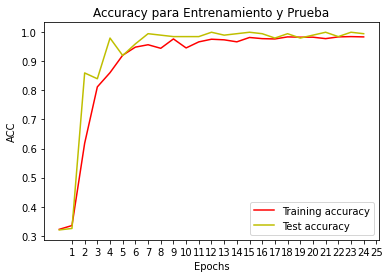

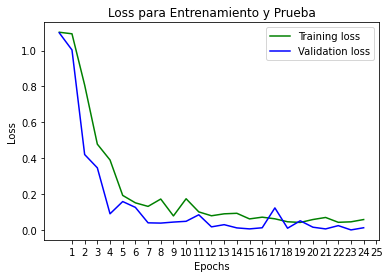

In [9]:
# History variables
loss_train= history.history['loss']
loss_test = history.history['val_loss']

acc_train = history.history['accuracy']
acc_test = history.history['val_accuracy']

epochs_plot = range(1,epocas+1)

# Gráfica de acc vs epochs
plt.plot(acc_train, 'r', label='Training accuracy')
plt.plot(acc_test,'y', label='Test accuracy')
plt.xticks(epochs_plot)
plt.title('Accuracy para Entrenamiento y Prueba')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

# Gráfica de loss vs epochs
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_test,'b', label='Validation loss')
plt.xticks(epochs_plot)
plt.title('Loss para Entrenamiento y Prueba')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Confusion Matrix


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

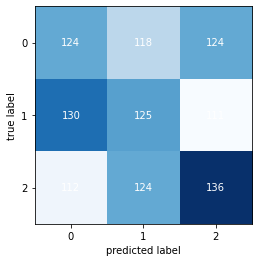

In [23]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

Y_pred = cnn.predict(imagen_test)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
plot_confusion_matrix(confusion_matrix(imagen_test.classes, y_pred))

#print('Classification Report')
#target_names = ['Cats', 'Dogs']
#print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

## Probando nuestro modelo

In [11]:
modelo_entrenado = './modelo/modelo.h5'
pesos = './modelo/pesos.h5'
red = load_model(modelo_entrenado)
red.load_weights(pesos)

In [12]:
def predict(file):
    img_source = cv2.imread(file)
    ejemplo_img_papel = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)
    plt.imshow(ejemplo_img_papel)
    
    flag = False
    x=load_img(file, target_size=(longitud, altura))
    x=img_to_array(x)
    x=np.expand_dims(x,axis=0)
    arreglo = cnn.predict(x) #[1,0,0]
    
    resultado=arreglo[0] 
    #print('Arreglo :',type(resultado),'  ', arreglo)

    for i in range(0,3):
        #print(' - ',i,' - ',resultado[i])
        if resultado[i]>0.7:
            flag=True
           
    if flag==True:        
        respuesta = np.argmax(resultado)
        if respuesta==0:
            print("Papel")
        elif respuesta == 1:
            print("Roca")
        elif respuesta == 2:
            print("Tijera")
    else:
        respuesta=3
        print("Nada")
    #return respuesta
    

### Imagenes del conjunto de test

Papel


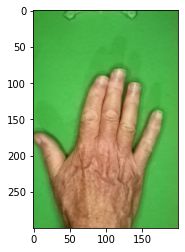

In [13]:
predict('dataset_imagenes/probando/1.png')

Tijera


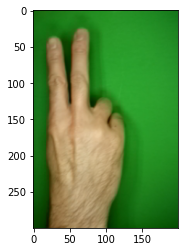

In [14]:
predict('dataset_imagenes/probando/2.png')

Roca


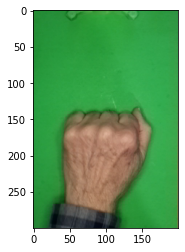

In [15]:
predict('dataset_imagenes/probando/6.png')

### Fotos tomadas con mi celular de mi mano

Papel


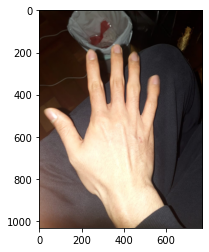

In [16]:
predict('dataset_imagenes/probando/3.jpg')


Tijera


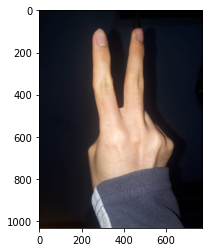

In [17]:
predict('dataset_imagenes/probando/4.jpeg')

Roca


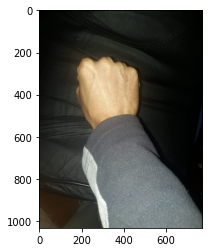

In [18]:
predict('dataset_imagenes/probando/7.jpeg')

### Cualquier imagen de internet con los mismos gestos

Tijera


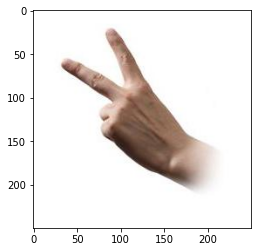

In [19]:
predict('dataset_imagenes/probando/web1.jpg')

Roca


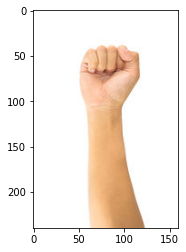

In [20]:
predict('dataset_imagenes/probando/web2.jpg')

Papel


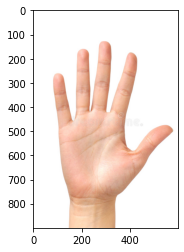

In [21]:
predict('dataset_imagenes/probando/web3.jpg')

## Problemas No Resuelto - Inquietudes

• Learning Rate como factor crítico

• Transfer Learning incompatibilidad de capas

• Como manejar las predicciones nulas para implementación en tiempo real
• Manejos de pines y pulsos hasta esperar recepción de cámara es la raspberry

• Capas muy profundas no funcionaron sobre este proyecto
• Tamaño de la imagen/velocidad/calidad de entrenamiento


## Conclusiones

• La relación de batch size y número de pasos afectan a la velocidad del aprendizaje pero no a la calidad del aprendizaje
• El tener capas altamente densas no garantiza buenos resultados, lo que lo hace es el anpalisis correcto de que capa utilizar y con que densidad y función de activación.
• Las redes neuronales convolucionales son muy importantes y permiten realizar aplicaciones en todas las áreas.
• El número de impagenes para entrenamiento es muy importante se debe realizar data aucmentation
• Los datos deben estar limpios y equilibrados para conseguir un buen resultado